# BDA Assignment 2

Overall Task: Find similar regions of Long Island by comparing satellite imagery.
- Objectives:
    - Implement Locality Sensitive Hashing.
    - Implement dimensionality reduction -- learn through doing.
    - Gain further experience with Spark.
    - Gain further experience with data preprocessing.
    - Explore a different modality of data: satellite images.

## Boring stuff

In [1]:
import zipfile
import io

from tifffile import TiffFile
from pyspark import SparkContext, SparkConf
import numpy as np

In [2]:
import hashlib

In [3]:
import matplotlib.pyplot as plt

In [4]:
sc = SparkContext()

***
***
# Task 1a, 1b: 
- Create an rdd of the orthographic zip files in the specified location. Pull the filenames out from the rest of the path (e.g. ‘/data/ortho/small_sample/3677453_2025190.zip’ => ‘3677453_2025190.zip’) and make sure to hang on to it.
- Find all the tif files and convert them into arrays (make sure to hang on to the image filename).The following method may be useful:

In [5]:
def getOrthoTif(zfBytes):
    # given a zipfile as bytes (i.e. from reading from a binary file),
    # return a np array of rgbx values for each pixel
    bytesio = io.BytesIO(zfBytes)
    zfiles = zipfile.ZipFile(bytesio, "r")
    # find tif:
    for fn in zfiles.namelist():
        if fn[-4:] == '.tif':  # found it, turn into array:
            tif = TiffFile(io.BytesIO(zfiles.open(fn).read()))
            return tif.asarray()

In [6]:
rdd_1a = sc.binaryFiles('./*.zip')
rdd_1b = rdd_1a.map(lambda x: (x[0], getOrthoTif(x[1])))

***
# Task 1c, 1d:
- Divide the image into 25 evenly sized 500x500 subimages. Each tif image should be 2500x2500 or 5000x5000 pixels, so you will end up with 25 500x500 images (image breaking the image into a 5x5 grid) or 100 500x500 images.
- Produce a final RDD where each record is of the form: (imagename, array).

In [7]:
def split_images(name, img, new_size=500):
    factor = int(img.shape[0]/new_size)
    file_name = name.split('/')[-1]
#     print(factor)
#     x = rdd_tiff_array.take(1)[0][1]
    y = np.array(np.split(img, factor, 1))
    y = np.array(np.split(y, factor, 1))
    z = y.reshape([y.shape[0]*y.shape[1]]+list(y.shape[2:]))
    result = list()
    for i, arr in enumerate(z):
        result.append((file_name+'-'+str(i), arr))
    return result

rdd_1d = rdd_1b.flatMap(lambda x: split_images(x[0], x[1]))

3677454_2025195.zip-0


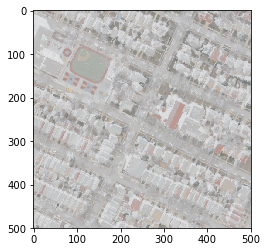

In [8]:
x = rdd_1d.filter(lambda x: '-0' in x[0]).first()
print(x[0])
plt.imshow(x[1])
plt.show()

***
## Task 1e
Print the r, g, b, x values for the pixel (0,0) in the following images:
<br>3677454_2025195.zip-0, 3677454_2025195.zip-1, 3677454_2025195.zip-18, 3677454_2025195.zip-19


In [9]:
print(rdd_1d.filter(lambda x: '3677454_2025195.zip-0'==x[0]).first()[1][0][0])
print(rdd_1d.filter(lambda x: '3677454_2025195.zip-1'==x[0]).first()[1][0][0])
print(rdd_1d.filter(lambda x: '3677454_2025195.zip-18'==x[0]).first()[1][0][0])
print(rdd_1d.filter(lambda x: '3677454_2025195.zip-19'==x[0]).first()[1][0][0])

[114 111 109 114]
[ 54  53  57 117]
[ 79  70  66 123]
[61 57 63 84]


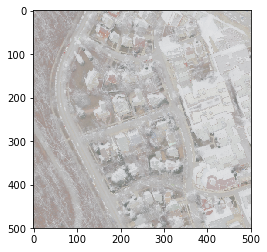

In [10]:
plt.imshow(rdd_1d.filter(lambda x: '3677454_2025195.zip-19'==x[0]).first()[1])
plt.show()

***
***
## Step 2. Turn each image into a feature vector (25 points)
For each 500x500 image (each image should be an RDD record):
## Step 2a:
Convert the 4 values of each pixel into a single value, 
> __intensity = int(rgb_mean \* (infrared/100))__

rgb_mean: the mean value of the red, green, and blue values for the pixel  
infrared: (the 4th value in the tuple for the pixel)  

>E.g. if the pixel was (10, 20, 30, 65), rgb_mean would be 20 and infrared would be 65. <br>Thus, intensity = int(20 \* (65/100)) = 13

In [11]:
def convert_to_one_channel(img):
    img = img.astype(np.float)
    x = np.mean(img[:, :, :3], axis=2)*img[:,:,3]/100
#     plt.imshow(x)
#     plt.show()
    return x

rdd_2a = rdd_1d.map(lambda x: (x[0], convert_to_one_channel(x[1])))

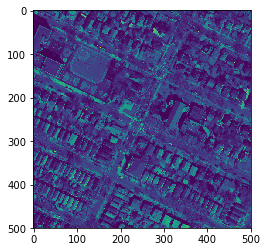

In [12]:
plt.imshow(rdd_2a.first()[1])
plt.show()

## Task 2b
Reduce the resolution of each image by factor = 10.  
For example, from 500x500 to 50x50.  
To do this, take the mean intensity over factor x factor (10x10) sub-matrices.  
(Note one might build on the method for step 1(c); factor may change for later steps).

In [13]:
def reduce_resolution(img, factor=10):
    section_size = img.shape[0]/factor
    y = np.array(np.split(img, section_size, 1))
    y = np.array(np.split(y, section_size, 1))
    z = np.mean(y, axis=(2,3))
    return z

rdd_2b = rdd_2a.map(lambda x: (x[0], reduce_resolution(x[1])))

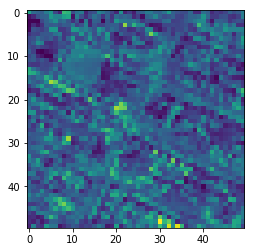

In [14]:
result = rdd_2b.first()[1]
plt.imshow(result)
plt.show()

In [15]:
rdd_2b.filter(lambda x: '3677454_2025195.zip-1'==x[0]).first()[1]

array([[ 142.16346667,  185.1936    ,  141.47336667, ...,   90.74706667,
         120.69823333,   36.14373333],
       [  96.54653333,  104.79393333,  131.27826667, ...,   77.5871    ,
          87.31963333,   60.6824    ],
       [  69.7174    ,   66.22443333,   86.27263333, ...,  114.48206667,
          88.76406667,   97.09666667],
       ..., 
       [ 139.6241    ,  173.28233333,  121.39633333, ...,   92.8668    ,
          88.2297    ,  132.01726667],
       [ 109.2507    ,  150.5544    ,  161.75443333, ...,  148.86976667,
         118.97243333,   86.1533    ],
       [ 105.05423333,   55.34963333,  157.7328    , ...,  127.14366667,
         136.15826667,  130.6269    ]])

## Task 2c, 2d, 2e
Compute the row difference in intensities. Direct intensity is not that useful because of shadows. Instead we focus on change in intensity by computing how it changes from one pixel to the next. Specifically we say intensity[i] = intensity[i+1] - intensity[i] (the numpy function ‘diff’ will do this). Then we turn all values into 3 possible values: Convert all values < -1 to -1, those > 1 to 1, and the rest to 0.  
e.g. if the row was: [10, 5, 4, 10, 1], then the diff would be [-5, -1, 6, -9] and the vector after conversion would be [-1, 0, 1, -1] (notice there is one less column after doing this).  
We call this row_diff

Compute the column difference in intensities. Do this over the direct intensity scores -- not row_diff. we call this col_diff

Turn row_diff and col_diff into one long feature vector.  
Row_diff and col_diff are matrices.  
Flatten them into long vectors, then append them together.  
Call this features. Row_diff has 50rows x 49columns = 2450 values  
and col_diff has 49x50 = 2450 values.  
Thus, features will have 2450 + 2450 = 4900 values,

In [16]:
def convert_values(arr, axis):
    arr = np.diff(arr, axis=axis)
    arr = np.where(np.logical_or(arr<-1, arr>1), arr, 0)
    arr = np.clip(arr, -1, 1)
    arr = arr.reshape(arr.shape[0]*arr.shape[1])
    return arr

rdd_2e = rdd_2b.map(lambda x: (x[0], np.hstack((convert_values(x[1], 1), (convert_values(x[1], 0))))))

## Task 2f
Print the feature vectors for: 3677454_2025195.zip-1, 3677454_2025195.zip-18

In [17]:
rdd_2f_1 = rdd_2e.filter(lambda x: '3677454_2025195.zip-1'==x[0])
rdd_2f_18 = rdd_2e.filter(lambda x: '3677454_2025195.zip-18'==x[0])
print(rdd_2f_1.first()[1])
print(rdd_2f_18.first()[1])

[ 1. -1. -1. ..., -1.  1.  1.]
[ 1.  1. -1. ...,  1.  1.  1.]


***
***
## Step 3. Use LSH, PCA to find similar images (50 points)
***
## Task 3a
Create a 16 byte “signature” for each image:  
Pass the feature vector, in 128 similarly-sized chunks (e.g. a combination of 38 and 39 features per chunk), to an md5 hash function and take one bit from the hash per chunk in order to end up with 128 bits (or 16 bytes).  

This is analogous to the signature you get per document at the end of minhashing.  

Here, we are not using minhashing but the next steps for LSH are the same as if we had just produced a signature matrix using minhashing.

In [18]:
def create_signature(vec):
    vec_arr = np.array_split(vec, 128)
    result = list()
    for item in vec_arr:
        a = hashlib.md5(item)
        b = a.hexdigest()
        as_int = int(b, 16)
        result.append(as_int%2)
    return 1*np.array(result, dtype=np.bool)

rdd_3a = rdd_2e.map(lambda x: (x[0], create_signature(x[1])))

In [19]:
rdd_3a.first()[1]

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1])

***
## Task 3b
Out of all images, run LSH to find approximately 20 candidates that are most similar to images:  

3677454_2025195.zip-0, 3677454_2025195.zip-1, 3677454_2025195.zip-18, 3677454_2025195.zip-19.  
Treat the signature vector as *bits* (i.e. if the number of bands is 8, then you are hashing 16 bits per band)  
Note that while you might have things stored as rows being signature vectors for images, the slides depict columns as the signature vectors.  

- Tweak brands and rows per band in order to get approximately 20 candidates (i.e. anything between 15 to 25 candidates is ok).  
Note that there are 16 rows total, which you can divide evenly into 1, 2, 4, or 8 bands, but you’re also welcome to divide into a number that doesn’t evenly fit, in which case just leave out the remainder (e.g. 3 bands of 5 rows, and ignore the last row).  


- Note that in LSH the columns are signatures. Here each RDD record is a signature, and so from the perspective of LSH, each record is a column.  


- While pre existing hash code is fine, you must implement LSH otherwise.  
__print the 20 candidates for 3677454_2025195.zip-1, 3677454_2025195.zip-18__

In [20]:
%%time
def LSH(vec, bands=16, buckets=671):
    band_split = np.split(vec, bands)
    result = []

    for i,bi in enumerate(band_split):
        a = hashlib.md5(band_split[0])
        b = a.hexdigest()
        result.append((i, hash(np.array_str(bi))% buckets))
    return result

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 8.82 µs


In [21]:
%%time
rdd_3b_1 = rdd_3a.flatMap(lambda x:  [(item, x[0]) for item in LSH(x[1])]).groupByKey().mapValues(list)
rdd_3b = rdd_3b_1.flatMap(lambda x: [(item, x[1]) for item in x[1]]).reduceByKey(lambda a,b: list(set(a+b)))

CPU times: user 22.9 ms, sys: 5.66 ms, total: 28.6 ms
Wall time: 65.7 ms


***
## Task 3c
For each of the candidates from (b), use PCA and find the euclidean difference in low dimensional feature space of the images.

        The following is provided as an aid to understand SVD: 
        CSE545: SVD Programming Handout
        

1. Start by running PCA across the 4900 dimensional feature vectors of *all* images to reduce the feature vectors to only 10 dimensions.  
You must run this steps across partitions within spark (use concepts of the course to figure out how to do this; there is no single correct approach and approximate solutions are ok).  
For example, one option is to run SVD separately on different samples (i.e. random batches) and then combine all the low dimensional batches into one.  

2. Solutions that are particularly efficient and accurate may receive extra credit. You may lookup how distributed statistics libraries distribute PCA/SVD but you must abide by policies of academic integrity and not copy code in part or whole.

3. Then, compute the euclidean distance between 3677454_2025195.zip-1, 3677454_2025195.zip-18, and each of their (max 20) candidates within this 10 dimensional space.  (can be done outside RDDs)
**print the distance scores along with their associated imagenames, sorted from least to greatest

In [22]:
def getSVD(arr, dimens=10):
    global broadcast_mu, broadcast_std, broadcast_Vh
    mat = np.zeros((len(arr), arr[0][1].shape[0]), dtype=np.float)
    for i,l in enumerate(arr):
        mat[i] = np.array(l[1])
    mu, std = np.mean(mat, axis=0), np.std(mat, axis=0)
    mat_zs = (mat - mu) / std
    U, s, Vh = np.linalg.svd(mat_zs, full_matrices=0)
    broadcast_mu = sc.broadcast(mu)
    broadcast_std = sc.broadcast(std)
    broadcast_Vh = sc.broadcast(Vh[:dimens].T)
#     print(broadcast_Vh.value.shape)
    return
# approx_mat_zs = np.dot(U[:,0:dimens], np.dot(np.diag(s[0:dimens]), Vh[0:dimens,:]))
# # to get back to an image: reverse standardization


In [23]:
batch = rdd_2e.take(25)
getSVD(batch)

(4900, 10)


In [29]:
def transform(feature):
    feature_zs = (feature-broadcast_mu.value) / broadcast_std.value
    t1 = np.dot(feature_zs, broadcast_Vh.value)
    t2 = np.matmul(feature_zs, broadcast_Vh.value)
    return np.dot(feature_zs, broadcast_Vh.value)

rdd_3c_0 = rdd_2e.map(lambda x: (x[0], transform(x[1])))

rdd_3c_1 = rdd_3b.join(rdd_3c_0).flatMap(lambda x: [(item, (x[0],x[1][1])) for item in x[1][0] if item!=x[0]])

def distance(d1, d2):
    return np.linalg.norm(d1-d2)

rdd_3c_2 = rdd_3c_1.join(rdd_3c_0).map(lambda x: (x[1][0][0], (x[0], distance(x[1][0][1],x[1][1]))))

rdd_3c_3 = rdd_3c_2.groupByKey().mapValues(list)

def sort_by_dist(pair):
    key, value = pair
    value.sort(key=lambda t: t[1])
    return key, value
rdd_3c = rdd_3c_3.map(sort_by_dist)

In [31]:
import pprint

In [33]:
rdd_3c_1 = rdd_3c.filter(lambda x: '3677454_2025195.zip-1'==x[0])
rdd_3c_18 = rdd_3c.filter(lambda x: '3677454_2025195.zip-18'==x[0])
pprint.pprint(rdd_3c_1.first()[1])
pprint.pprint(rdd_3c_18.first()[1])

[('3677500_2035190.zip-17', 50.601650444294656),
 ('3677502_2035200.zip-6', 51.6015513800319),
 ('3677453_2025190.zip-0', 52.286280183298871),
 ('3677502_2035200.zip-13', 52.919475348704736),
 ('3677501_2035195.zip-7', 53.161931352632621),
 ('3677453_2025190.zip-20', 53.217692458807115),
 ('3677453_2025190.zip-9', 53.41184799850511),
 ('3677502_2035200.zip-22', 53.557952615702291),
 ('3677453_2025190.zip-12', 53.596719688352465),
 ('3677500_2035190.zip-6', 55.151102107788134),
 ('3677454_2025195.zip-17', 57.096403314719502),
 ('3677454_2025195.zip-20', 66.134879053561022),
 ('3677454_2025195.zip-3', 83.487893878865549)]
[('3677502_2035200.zip-8', 37.591075553049535),
 ('3677501_2035195.zip-2', 37.901569167373935),
 ('3677453_2025190.zip-13', 38.239513106856357),
 ('3677501_2035195.zip-3', 38.685975261687297),
 ('3677500_2035190.zip-14', 39.243610576502448),
 ('3677500_2035190.zip-17', 39.880537447985667),
 ('3677454_2025195.zip-14', 56.632650717143107),
 ('3677454_2025195.zip-2', 63.36

In [34]:
final_result = rdd_3c.collect()

In [35]:
def compare_images(name, arr):
    fig = plt.figure(figsize=(14, 6))
    for i, el in enumerate(arr):
        #moving axis to use plt: i.e [4,100,100] to [100,100,4]
        ax = plt.subplot(1, 3, i + 1)
        ax.set_title(name[i])
        plt.imshow(el)      # <- I changed this line
    plt.savefig('plt-'+name[0]+'.png')
    plt.show()
    return

In [ ]:
for img, list_img in final_result[:5]:
    arr = [rdd_1d.filter(lambda x: img==x[0]).first()[1]]
    name = [img]
    for img1 in list_img[:2]:
        arr.append(rdd_1d.filter(lambda x: img1[0]==x[0]).first()[1])
        name.append(img1)
    compare_images(name, arr)